** Introduction **

This project looks at communal bike rentals in the Washington D.C. area. The dataset includes information around the time of rental and the weather. Our goal of this project is to test different modles to see if we can predict the total number of bikes rented in a given hour (the 'cnt' column - which is a combination of the casual and registered columns). We will use Linear Regression, a Decision Tree and Random Forest to make our predictions. 

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [3]:
# Exploring the initial data

print(bike_rentals.head(10))

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   
5        6  2011-01-01       1   0     1   5        0        6           0   
6        7  2011-01-01       1   0     1   6        0        6           0   
7        8  2011-01-01       1   0     1   7        0        6           0   
8        9  2011-01-01       1   0     1   8        0        6           0   
9       10  2011-01-01       1   0     1   9        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81     0.0000       3          13   16

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

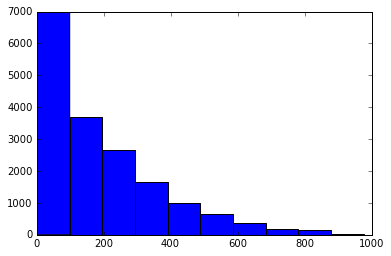

In [4]:
# Gain insight on the 'cnt' column:

plt.hist(bike_rentals['cnt'])

In [5]:
# Explore the correlations with the 'cnt' column:

cor_map = bike_rentals.corr()
print(abs(cor_map['cnt']).sort_values())

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
instant       0.278379
hum           0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


In [6]:
# Change the hour variable to a time of day variable

def assign_label(hour):
    if 6 > hour <= 12:
        tod = 1
    elif 12 > hour <= 18:
        tod = 2
    elif 18 > hour <= 24:
        tod = 3
    else:
        tod = 4
    return tod

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [7]:
# Re-look at the correlations with the time_label column.

cor_map = bike_rentals.corr()
print(abs(cor_map['cnt']).sort_values())

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
instant       0.278379
hum           0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
time_label    0.422126
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


** ERROR METRIC **

We will use the RMSE metric to measure our data.

We will start with linear regression on the data for our prediction.

In [8]:
# First we need to randomize and split up the data into train 
# and test groups.

In [9]:
bike_rentals = bike_rentals.sample(frac=1).reset_index(drop=True)
split_num = math.floor(bike_rentals.shape[0] * .8)
train = bike_rentals.iloc[:split_num]
test = bike_rentals.iloc[split_num:]


In [10]:
# Now we need to create a list of columns to use for our regression
# We will remove 'cnt', 'casual' and 'registered' because they would
# inform the algorithm of the answer. We will remove 'atemp'
# because it is a function of temp and we don't want to duplicate.
# We will also remove dteday. 

features = list(bike_rentals.drop(['cnt',
                               'casual',
                               'registered',
                               'atemp',
                               'dteday'], axis=1
                            ).columns)

In [11]:
lr = LinearRegression()
lr.fit(train[features],train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
predictions = lr.predict(test[features])
lr_rmse = mean_squared_error(test['cnt'],predictions)**(1/2)
print('Test RMSE: ',lr_rmse)

Test RMSE:  140.02498009201648


** Analysis of RMSE**

This RMSE seems high. This could be from the distribution of the data. Most of the rentals are low but some are extremely high and those may be getting penalized by the Linear Regression model.

In [13]:
dtr = DecisionTreeRegressor()
dtr.fit(train[features],train['cnt'])

predictions = dtr.predict(test[features])
dt_rmse = mean_squared_error(test['cnt'], predictions)**(1/2)
print('Test RMSE: ', dt_rmse)

Test RMSE:  57.53472209249011


The RMSE is extremely high pointing to severe overfitting. Let's try to tweak it a bit and find out what the best parameters and values would be to change. We'll start with min_samples and then test depth.

In [14]:
for i in range(1,11):
    dtr = DecisionTreeRegressor(min_samples_leaf=i)
    dtr.fit(train[features],train['cnt'])
    
    predictions = dtr.predict(test[features])
    dt_rmse = mean_squared_error(test['cnt'], predictions)**(1/2)
    print('Test RMSE',i,'min_sample_leaf: ', dt_rmse)

Test RMSE 1 min_sample_leaf:  56.17407546983465
Test RMSE 2 min_sample_leaf:  51.4998384667567
Test RMSE 3 min_sample_leaf:  50.64805261000953
Test RMSE 4 min_sample_leaf:  49.872696810633535
Test RMSE 5 min_sample_leaf:  49.85990412383016
Test RMSE 6 min_sample_leaf:  49.82276486340461
Test RMSE 7 min_sample_leaf:  50.12602319544563
Test RMSE 8 min_sample_leaf:  50.40822005051152
Test RMSE 9 min_sample_leaf:  50.742867000998324
Test RMSE 10 min_sample_leaf:  50.61971051881094


In [15]:
for i in range(10,36):
    dtr = DecisionTreeRegressor(max_depth=i, min_samples_leaf=5)
    dtr.fit(train[features],train['cnt'])
    
    predictions = dtr.predict(test[features])
    dt_rmse = mean_squared_error(test['cnt'], predictions)**(1/2)
    print('Test RMSE',i,'max_depth: ', dt_rmse)

Test RMSE 10 max_depth:  57.45390957522606
Test RMSE 11 max_depth:  53.95801508057443
Test RMSE 12 max_depth:  52.13574324508572
Test RMSE 13 max_depth:  50.80867112040207
Test RMSE 14 max_depth:  50.02784173635927
Test RMSE 15 max_depth:  49.90533003873262
Test RMSE 16 max_depth:  50.0097848010563
Test RMSE 17 max_depth:  49.66862451668388
Test RMSE 18 max_depth:  49.92936790176642
Test RMSE 19 max_depth:  49.769556560181535
Test RMSE 20 max_depth:  49.97218173073685
Test RMSE 21 max_depth:  49.883801457126
Test RMSE 22 max_depth:  49.86479235577875
Test RMSE 23 max_depth:  49.84970232353811
Test RMSE 24 max_depth:  49.78910449438584
Test RMSE 25 max_depth:  49.98963683597963
Test RMSE 26 max_depth:  49.80465960339818
Test RMSE 27 max_depth:  49.73871530208742
Test RMSE 28 max_depth:  49.8322844267886
Test RMSE 29 max_depth:  49.82284549014391
Test RMSE 30 max_depth:  49.78609949820087
Test RMSE 31 max_depth:  49.76965304633447
Test RMSE 32 max_depth:  49.98865587944474
Test RMSE 33 m

In [16]:
dtr = DecisionTreeRegressor(max_depth = 24,min_samples_leaf = 5)
dtr.fit(train[features],train['cnt'])
    
predictions = dtr.predict(test[features])
dt_rmse = mean_squared_error(test['cnt'], predictions)**(1/2)
print('Test RMSE max_depth = 24, min_samples_leaf = 5: ', dt_rmse)

Test RMSE max_depth = 24, min_samples_leaf = 5:  49.694285123745686


** Quick Analysis **

After playing around with it a little, it looks like the optimal spot may be somewhere around 5 min sample leafs and 24 max depth. If we wanted to be even more sure we could run multiple iterations of this and take the average. With this data and these features we could get our RMSE down more easily with min_samples_leaf than max_depth. It is probably worth dropping max_depth to speed up the operation, especially if we were working with a larger data set.

Compared to Linear Regression, the Decision Tree Regressor produced a significantly better RMSE value. 

Next we try applying a Random Forest Regressor. We'll start with the default setting and then experiment with the parameters.

In [21]:
rfr = RandomForestRegressor()
rfr.fit(train[features],train['cnt'])

predictions = rfr.predict(test[features])
rfr_rmse = mean_squared_error(test['cnt'],predictions)**(1/2)
print('Test RMSE: ',rfr_rmse)

Test RMSE:  44.22067839352342


We can already see that the random forest regressor is fitting better to the data than either the linear regression model or the decision tree model.

In [24]:
for i in range(1,11):
    rfr = RandomForestRegressor(min_samples_leaf = i)
    rfr.fit(train[features],train['cnt'])
    
    predictions = rfr.predict(test[features])
    rfr_rmse = mean_squared_error(test['cnt'],predictions)**(1/2)
    
    print('Test RMSE with min_sample_leaf =',i,':',rfr_rmse)
    

Test RMSE with min_sample_leaf = 1 : 42.40520315144481
Test RMSE with min_sample_leaf = 2 : 43.93583347223653
Test RMSE with min_sample_leaf = 3 : 43.42160125236751
Test RMSE with min_sample_leaf = 4 : 42.665645362975795
Test RMSE with min_sample_leaf = 5 : 43.23000203531048
Test RMSE with min_sample_leaf = 6 : 44.55830945001479
Test RMSE with min_sample_leaf = 7 : 44.29162679848522
Test RMSE with min_sample_leaf = 8 : 45.469474356145575
Test RMSE with min_sample_leaf = 9 : 45.46561971367632
Test RMSE with min_sample_leaf = 10 : 46.494637370078784


In [27]:
for i in range(5,31):
    rfr = RandomForestRegressor(max_depth = i)
    rfr.fit(train[features],train['cnt'])
    
    predictions = rfr.predict(test[features])
    rfr_rmse = mean_squared_error(test['cnt'],predictions)**(1/2)
    
    print('Test RMSE with max_depth =',i,':',rfr_rmse)

Test RMSE with max_depth = 5 : 106.42065053847816
Test RMSE with max_depth = 6 : 96.94846406862241
Test RMSE with max_depth = 7 : 77.55125786100407
Test RMSE with max_depth = 8 : 63.51726870473583
Test RMSE with max_depth = 9 : 55.077035918129404
Test RMSE with max_depth = 10 : 51.267290578189716
Test RMSE with max_depth = 11 : 48.241792003909055
Test RMSE with max_depth = 12 : 45.096648081816184
Test RMSE with max_depth = 13 : 44.53405419880526
Test RMSE with max_depth = 14 : 44.25946627815348
Test RMSE with max_depth = 15 : 43.221324691509956
Test RMSE with max_depth = 16 : 43.236465528132726
Test RMSE with max_depth = 17 : 42.881675514838285
Test RMSE with max_depth = 18 : 43.03986080162767
Test RMSE with max_depth = 19 : 41.745910248954935
Test RMSE with max_depth = 20 : 42.85420246624095
Test RMSE with max_depth = 21 : 43.7905443005039
Test RMSE with max_depth = 22 : 43.40525234706869
Test RMSE with max_depth = 23 : 42.7564075274159
Test RMSE with max_depth = 24 : 42.3319118115684

In [28]:
for i in range(1,31):
    rfr = RandomForestRegressor(n_estimators=i)
    rfr.fit(train[features],train['cnt'])
    
    predictions = rfr.predict(test[features])
    rfr_rmse = mean_squared_error(test['cnt'],predictions)**(1/2)
    
    print('Test RMSE with n_estimators =',i,':',rfr_rmse)

Test RMSE with n_estimators = 1 : 61.0588931686674
Test RMSE with n_estimators = 2 : 54.60655512904096
Test RMSE with n_estimators = 3 : 49.26225324405073
Test RMSE with n_estimators = 4 : 46.939648553225716
Test RMSE with n_estimators = 5 : 45.21351850349686
Test RMSE with n_estimators = 6 : 43.0819661955827
Test RMSE with n_estimators = 7 : 43.52227961032728
Test RMSE with n_estimators = 8 : 43.715068456487074
Test RMSE with n_estimators = 9 : 43.24218359164547
Test RMSE with n_estimators = 10 : 43.84081119370374
Test RMSE with n_estimators = 11 : 42.673241161492825
Test RMSE with n_estimators = 12 : 42.630798598335275
Test RMSE with n_estimators = 13 : 42.355544932030625
Test RMSE with n_estimators = 14 : 42.04462166986254
Test RMSE with n_estimators = 15 : 42.2571004301053
Test RMSE with n_estimators = 16 : 42.7342376483036
Test RMSE with n_estimators = 17 : 40.51342106788624
Test RMSE with n_estimators = 18 : 41.36823888095526
Test RMSE with n_estimators = 19 : 41.99649524098717
T

Now that we have some idea of the optimal spots for our parameters lets try a combo.

In [51]:
rmse_list = []

kf = KFold(n_splits=10,shuffle=True)
X = bike_rentals.index

for train_index, test_index in kf.split(X):
    train = bike_rentals.iloc[train_index]
    test = bike_rentals.iloc[test_index]
    
    rfr = RandomForestRegressor(max_depth = 19, n_estimators = 29)
    rfr.fit(train[features],train['cnt'])
    
    predictions = rfr.predict(test[features])
    rfr_rmse = mean_squared_error(test['cnt'],predictions)**(1/2)
    
    rmse_list.append(rfr_rmse)
    
    print('Test RMSE: ',rfr_rmse)
    
avg_rmse = np.mean(rmse_list)
print('')
print('Avg RMSE for Random Forest:', avg_rmse)

Test RMSE:  38.533008881148696
Test RMSE:  41.21640049461768
Test RMSE:  41.328605556472986
Test RMSE:  43.03447820090611
Test RMSE:  42.647576587352106
Test RMSE:  42.37705339734473
Test RMSE:  39.48390867311073
Test RMSE:  41.626729099425695
Test RMSE:  40.86559493900309
Test RMSE:  40.90189174329043

Avg RMSE for Random Forest: 41.20152475726722


** Conclusion **

We were able to get our RMSE down from 140.0 inially with linear regression to 41.2 with our random forest model. This was a great example of how different models work and how to test them.